Steps for defect detection project: <br>
***Preprocessing on sample image:*** <br>
1 - Shade out area of interest (circle detection) <br>
2 - Align any slightly rotated dials with template <br>
***Defect Detection on full dataset:*** <br>
3 - Fine-tune pretrained classifier on preprocessed (aligned) good/poor dial dataset if forthcoming. <br> 
4 - Local image similarity measures in comparison with template dial if in class "defect" <br>

1) Highlight dial area:

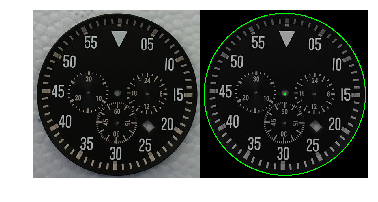

In [80]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.measure import compare_ssim
from skimage.filters import threshold_mean, gaussian
from skimage.util import img_as_ubyte
from skimage.color import gray2rgb

# grayscale conversion for cv functions:
def gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# import 
img = cv2.imread("sample/g.png")

img_hough = gray(img.copy())
# smooth image to make sure smaller features don't get captured as circles
img_hough = img_as_ubyte(gaussian(img_hough, sigma=0.0))
# ...and detect circles. 
circ = cv2.HoughCircles(img_hough, cv2.cv.CV_HOUGH_GRADIENT, 1.2, 100)
if circ is not None:
    circ = circ.squeeze()
    # sort potentially multiple circles and pick largest (by radius) as dial surface:
    if circ.size > 3:
        circ = circ[np.argmax(circ[:,2])]
    x,y,rad = circ.astype(int)
    img_hough = gray2rgb(img_hough)
    # mask image outside circle, classifier should only pay attention to dial surface:
    xx,yy = np.ogrid[0:img_hough.shape[0], 0:img_hough.shape[1]]
    mask = (xx-x)**2 + (yy-y)**2 >= rad**2
    img_hough[mask] = (0,0,0)
    # draw circle & center
    cv2.circle(img_hough, (x, y), rad, (0,255,0), 4)
    cv2.rectangle(img_hough, (x - 5, y - 5), (x + 5, y + 5), (0,255, 0), -1)

plt.imshow(np.hstack([img, img_hough]))
plt.axis("off")
plt.show()

2) Align dial to template & calculate rotation/transformation to get standard dial position for later classification

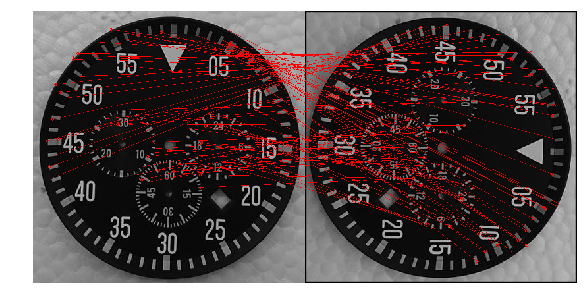

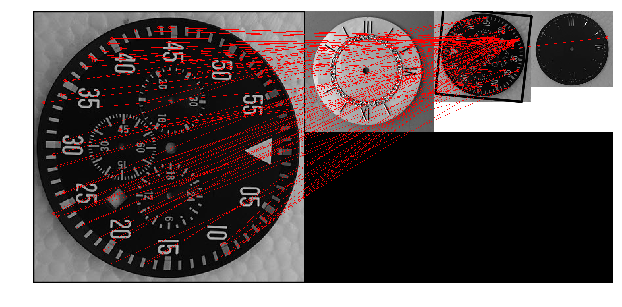

In [81]:
def drawMatches(img1, kp1, img2, kp2, matches):
    """
    Helper function for drawing image alignment feature matches (taken from opencv 3
    as not supported in cv 2.4)
    """
    # Create a new output image that concatenates the two images together
    # (a.k.a) a montage
    rows1 = img1.shape[0]
    cols1 = img1.shape[1]
    rows2 = img2.shape[0]
    cols2 = img2.shape[1]

    out = np.zeros((max([rows1,rows2]),cols1+cols2,3), dtype="uint8")

    # Place the first image to the left
    out[:rows1, :cols1] = np.dstack([img1])

    # Place the next image to the right of it
    out[:rows2, cols1:] = np.dstack([img2])

    # For each pair of points we have between both images
    # draw circles, then connect a line between them
    for mat in matches:
        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        # x - columns
        # y - rows
        (x1,y1) = kp1[img1_idx].pt
        (x2,y2) = kp2[img2_idx].pt

        # Draw a small circle at both co-ordinates
        # radius 4
        # colour blue
        # thickness = 1
        cv2.circle(out, (int(x1),int(y1)), 4, (255, 0, 0), 1)
        cv2.circle(out, (int(x2)+cols1,int(y2)), 4, (255, 0, 0), 1)

        # Draw a line in between the two points
        # thickness = 1
        # colour blue
        cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (255, 0, 0), 1)
    return out

def calculate_sift_matches(img1, img2, n_matches=100):
    """
    Take 2 images, calculate matching features and return comparison img + transformation matrix
    """
    # Initiate SIFT detector
    sift = cv2.SIFT()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    MIN_MATCH_COUNT = 10
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)

    # store good matches
    good_matches = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good_matches.append(m)

    if len(good_matches)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()

        h,w = img1.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)
        tup = tuple(np.int32(dst)[1,0])
        # cv2.circle(img2, tup, 30, color=(0,255,0))
        # rectangle to visualise transform matrix
        cv2.polylines(img2,[np.int32(dst)],True,(0,255,0),5, cv2.CV_AA)
    else:
        print "Not enough matches are found - %d/%d" % (len(good_matches),MIN_MATCH_COUNT)
        matchesMask = None
        """
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                       singlePointColor = None,
                       matchesMask = matchesMask, # draw only inliers
                       flags = 2)
        """
    # draw a max. of n_matches in the visualisation
    img3 = drawMatches(img1,kp1,img2,kp2,good_matches[:n_matches])
    return img3, dst

img = gray(cv2.imread("sample/g.png"))
img_rotated = gray(cv2.imread("sample/g_rot.png"))
bad = gray(cv2.imread("sample/bad.png"))

# try on single rotated image & ensemble image
matched_rot_img, _ = calculate_sift_matches(img, img_rotated)
matched_ensemble_img, _ = calculate_sift_matches(img_rotated, bad)

plt.figure(figsize=(16,5)) 
plt.imshow(matched_rot_img)
plt.axis("off")
plt.figure(figsize=(16,5)) 
plt.imshow(matched_ensemble_img)
plt.axis("off")
plt.show()

TBD pre-dataset:
Example alignment of multiple rotated dials <br>
TBD post-dataset: <br>
Classifier <br> 
Local image difference (SSIM) <br>